#3 Part III
#Kernel Perceptron (Handwritten Digit Classification)

In [1]:
# Import libraries
import numpy as np
import itertools as it
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data
combo = np.loadtxt('zipcombo.dat', usecols=range(257))

####Helper functions

In [3]:
# Divide data into train, test sets
def train_test(data):
  np.random.shuffle(data)
  len = int(data.shape[0] * 0.8)
  return data[:len, :], data[len:, :]

# Get image labels
def get_vals(data):
  return data[:, 0].astype(int)

# Encode image labels
def get_y(vals):
  y = np.eye(10)[vals]
  y[y == 0] = -1
  return y

# Get image data
def get_im(data):
  return data[:, 1:].astype(int)

# Compute classifier predictions
def cls_pred(kernel_val, cls):
  return np.dot(cls.T, kernel_val)

# Return signs of predictions
def sign(preds):
  return np.where(preds <=0, -1, 1)

# Compute accuracy
def mistake(preds, vals):
  return np.sum(preds != vals) / len(preds)

# Calculate mean and std
def mean_std(errors):
  return np.mean(errors), np.std(errors)

####Kernel computation functions

In [4]:
# Compute polynomial kernel values
def kernel(q, p, d):
  return np.dot(q[:, 1:258], p[:, 1:258].T)**d

# Compute Gaussian kernel values
def gaussian_kernel(q, p, c):
  sn_p = np.sum(q[:, 1:258]**2, axis=1)
  sn_d = np.sum(p[:, 1:258]**2, axis=1)
  t1 = sn_p[:, np.newaxis] + sn_d
  t2 = 2 * np.dot(q[:, 1:258], p[:, 1:258].T)
  return np.exp(-c * (t1 - t2))

####One vs. Rest: Training and testing functions

In [5]:
# Initialize OVR classifier
def cls_init(data):
  return np.zeros((data.shape[0], 10))

# Represent classifier update
def update(py, preds):
  return np.multiply(np.where(py <= 0, 1, 0), sign(preds))

# OVR training function
def train_cls(train, cls, kernels):

  # Get labels
  vals = get_vals(train)
  y = get_y(vals)
  max_preds = np.zeros((train.shape[0]))

  for i in range(len(train)):
    # Compute and save predictions
    preds = cls_pred(kernels[i, :], cls)
    max_preds[i] = np.argmax(preds)

    # Update classifier
    py = np.multiply(y[i], preds)
    cls[i] = cls[i] - update(py, preds)

  # Calculate error rate
  mistakes = mistake(max_preds, vals)
  return mistakes, cls

# OVR testing function
def test_cls(train, test, cls, d, poly):

  # Get labels
  vals = get_vals(test)

  # Compute kernel values
  if poly == True:
    kernels = kernel(test, train, d)
  else:
    kernels = gaussian_kernel(test, train, d)

  # Compute and save predictions
  preds = np.dot(cls.T, kernels.T)
  max_preds = np.argmax(preds, axis=0)

  # Calculate error rate
  mistakes = mistake(max_preds, vals)
  return mistakes, max_preds

# OVR train, test routine
def ovr_routine(train, test, kernels, d, poly):

  # Initialize classifier
  cls = cls_init(train)

  # Train model
  for epoch in range(12):
    train_error, cls = train_cls(train, cls, kernels)

  # Test model
  test_error, preds = test_cls(train, test, cls, d, poly)
  return train_error, test_error, preds

####One vs. One: Training and testing functions

In [6]:
# Initialize OVO classifier
def cls_init_ovo(data):
  return np.zeros((data.shape[0], int(10*9/2)))

# Majority voting function
def voting(preds, ovos):
  votes = np.zeros(10)

  # Compute predictions to binary
  signs = (sign(preds) + 2) // 2
  vote = [int(x) for x in signs]

  # Increment votes for winning class
  for i, j in enumerate(vote):
    votes[ovos[i][j]] += 1
  return np.argmax(votes)

# Classifier update function
def update_cls_ovo(i, cls, preds, vals, ovos):

  # Get prediction signs
  pred_signs = sign(preds)

  for j, (a, b) in enumerate(ovos):
    # Decrement weight if a was correct pred
    if vals[i] == a and pred_signs[j] != -1:
      cls[i, j] -= 1

    # Increment weight if b was correct pred
    elif vals[i] == b and pred_signs[j] != 1:
      cls[i, j] += 1
  return cls

# Vote counting function
def count_votes(vote_len, preds, ovos):

  votes = np.zeros((vote_len, 10))
  for i, (a, b) in enumerate(ovos):
    # Get signs of predictions
    signs = np.sign(preds[:, i])

    # Increment votes for a when -1
    votes[:, a] += (signs == -1)

    # Increment votes for b when 1
    votes[:, b] += (signs == 1)
  return votes

# OVO training function
def train_cls_ovo(train, cls, kernels):

  # Get labels, classifier pairs
  vals = get_vals(train)
  ovos = list(it.combinations(range(10), 2))
  max_preds = np.zeros((train.shape[0]))

  for i in range(len(train)):
    # Compute and save predictions
    preds = cls_pred(kernels[i, :], cls)
    max_pred = voting(preds, ovos)
    max_preds[i] = max_pred

    # Update classifier
    cls = update_cls_ovo(i, cls, preds, vals, ovos)

  # Calculate error rate
  mistakes = mistake(max_preds, vals)
  return mistakes, cls

# OVO testing function
def test_cls_ovo(train, test, cls, d, poly):

  # Get labels, classifier pairs
  vals = get_vals(test)
  ovos = list(it.combinations(range(10), 2))

  # Compute kernel values
  kernels = kernel(test, train, d)

  # Compute predictions
  preds = np.dot(cls.T, kernels.T).T

  # Get max votes for each point
  votes = count_votes(len(test), preds, ovos)
  max_preds = np.argmax(votes, axis=1)

  # Calculate error rate
  mistakes = mistake(max_preds, vals)
  return mistakes, max_preds

# OVO train, test routine
def ovo_routine(train, test, kernels, d, poly):

  # Initialize classifier
  cls = cls_init_ovo(train)

  # Train model
  for epoch in range(12):
    train_error, cls = train_cls_ovo(train, cls, kernels)

  # Test model
  test_error, preds = test_cls_ovo(train, test, cls, d, poly)
  return train_error, test_error, preds

####Optimal epoch determination functions

In [7]:
# Get epoch training and testing errors
def epoch_test(data, d, poly):

  # Divide data, compute kernel values
  train, test = train_test(data)
  kernels = kernel(train, train, d)

  # Initialize classifier
  cls = cls_init(train)
  e_test_errors = []
  e_train_errors = []

  # Train, test model 20 times, save errors
  for epoch in range(20):
    train_error, cls = train_cls(train, cls, kernels)
    test_error, preds = test_cls(train, test, cls, d, poly)

    # Save errors
    e_test_errors.append(test_error)
    e_train_errors.append(train_error)
  return e_test_errors, e_train_errors

# Model driver for epoch determination
def run_model_epochs(data, poly):
  d_test_errors = []
  d_train_errors = []

  # For dimensions 1-7
  for d in range(1, 8):
    print("Testing for d =", d)
    test_errors = []
    train_errors = []

    # Train, test model 20 times
    for i in range(20):
      e_test_errors, e_train_errors = epoch_test(data, d, poly)
      test_errors.append(e_test_errors)
      train_errors.append(e_train_errors)

    # Calculate mean and std of errors over runs
    d_test_errors.append(np.mean(test_errors, axis=0)*100)
    d_train_errors.append(np.mean(train_errors, axis=0)*100)
  return d_test_errors, d_train_errors

# Epoch error plot function
def epoch_subplots(errors, title):

  # Plot errors
  plt.figure(figsize=(7, 5))
  for i in range(len(errors)):
      plt.plot(range(1, 21), errors[i], label=f'd = {i+1}')
  plt.xticks(range(1, 21))
  plt.xlabel('Training Epochs')
  plt.ylabel(title+' Error %')
  plt.title(title+' Error Convergence Over Epochs')
  plt.legend(loc='upper right')
  plt.show()

# Plot basic results
def plot_epochs(data, poly):

  # Get test errors
  test_errors, train_errors = run_model_epochs(data, poly)

  epoch_subplots(train_errors, 'Training')
  epoch_subplots(test_errors, 'Testing')

####Basic results functions

In [8]:
# Get train, test errors
def err(train, test, poly, method, d):

  # Compute polynomial or Gaussian kernel values
  if poly == True:
    kernels = kernel(train, train, d)
  else:
    kernels = gaussian_kernel(train, train, d)

  # Train, test model with OVR or OVO
  if (method == 1):
    tr_err, te_err, preds = ovr_routine(train, test, kernels, d, poly)
  else:
    tr_err, te_err, preds = ovo_routine(train, test, kernels, d, poly)
  return tr_err, te_err, preds

# Main driver to run model
def run_model(data, poly, method, d1, d2):

  # Set parameter values
  print("Mean Errors with SD\n")
  d_range = np.linspace(d1, d2, 7)
  if poly == False:
    d_range = np.exp(d_range)

  for d in d_range:
    tr_err = np.zeros((20))
    te_err = np.zeros((20))

    # Train, test model 20 times
    for i in range(20):
      train, test = train_test(data)
      tr_err[i], te_err[i], preds = err(train, test, poly, method, d)

    # Calculate training mean and std of errors
    train_mean, train_std = mean_std(tr_err)
    test_mean, test_std = mean_std(te_err)

    print(f"d = {d}" if poly else f"c = {d:.4f}")
    print(f"Training: {train_mean*100:.4f} \u00B1 {train_std*100:.4f}%")
    print(f"Testing: {test_mean*100:.4f} \u00B1 {test_std*100:.4f}%\n")

####Cross-validation functions

In [9]:
# Divide data into one cv set
def k_train_test(data, k):

  # Get size for test set
  sz = int(data.shape[0] / 5)

  # Create train, test sets
  k_test = data[(k * sz):((k+1) * sz), :]
  k_train = np.vstack((data[:(k * sz), :], data[((k+1) * sz):, :]))
  return k_train, k_test

# Perform k-fold cv
def cv(train, d1, d2, method, poly):

  # For 5 k-folds
  test_errors = []
  for k in range(5):

    # Split into new train, test
    k_train, k_test = k_train_test(train, k)
    d_test_errors = []

    # Test each k-split on each d value
    d_range = np.linspace(d1, d2, 7)
    if poly == False:
      d_range = np.exp(d_range)
    for d in d_range:
      tr_err, te_err, preds = err(k_train, k_test, poly, method, d)
      d_test_errors.append(te_err)

    # Save errors for each d from each k-fold
    test_errors.append(d_test_errors)
  return test_errors

# Run model once using d* result from cv
def dstar_run(data, poly, method, d1, d2):
  train, test = train_test(data)

  # Get average errors across k-folds
  test_errors = cv(train, d1, d2, method, poly)
  d_test_error = np.mean(test_errors, axis=0)

  # Select d* from k-fold run
  if poly == True:
    best_d = np.argmin(d_test_error) + 1
  else:
    best_d = np.exp(np.linspace(d1, d2, 7))[np.argmin(d_test_error)]

  # Get train, test errors
  tr_err, te_err, preds = err(train, test, poly, method, best_d)

  # Save image, label data
  vals = get_vals(test)
  ims = get_im(test)
  return te_err, vals, preds, ims, best_d

# Save results and data from run with d*
def dstar_results(data, poly, method, d1, d2):
  test_errors = []
  ds = []
  vals = []
  im_data = []
  preds = []

  for i in range(20):
    if (i%2 == 0):
      print(f"Starting run {i+1}...")

    # Compute and save cross validation results and data
    te_err, vs, ps, ims, best_d = dstar_run(data, poly, method, d1, d2)
    test_errors.append(te_err)
    ds.append(best_d)
    vals.append(vs)
    im_data.append(ims)
    preds.append(ps)
  return test_errors, ds, vals, preds, im_data

# Main driver to run model with cv
def run_model_cv(data, poly, method, d1, d2):

    # Run cv and get results from d* runs
    te_err, ds, vs, ps, ims = dstar_results(data, poly, method, d1, d2)

    # Calculate test, d* mean and std
    test_mean, test_std = mean_std(te_err)
    d_mean, d_std = mean_std(ds)

    param = 'd' if poly else 'c'
    print("\nMean Errors with SD\n")
    print(f"Testing: {test_mean * 100:.4f} \u00B1 {test_std * 100:.4f}%")
    print("\nMean "+param+"* with SD\n")
    print("Mean "+param+f"* parameter: {d_mean :.4f} \u00B1 {d_std :.4f}")

    if (method == 1):
      return vs, ps, ims

####Confusion matrix functions

In [10]:
# Get count for one form of prediction-label error
def pred_label_err(vals, preds, counts, i, j):

  # Count instances of prediction-label error
  vals_i = np.where(vals == i, 1, 0)
  preds_j = np.where(preds == j, 1, 0)
  inst = np.logical_and(vals_i, preds_j)

  # Calculate occurrence rate
  return np.sum(inst)/counts[i]

# Get counts for all prediction-label errors
def confusion_matrix(vals, preds, ims):

  cm_errs = []
  for v in range(len(vals)):
    counts = np.unique(vals[v], return_counts=True)[1]
    cm_vals = []

    # For each label and prediction type
    for i in range(10):
      cm_sub = []
      for j in range(10):
        if i == j:
          cm_sub.append(0)
        else:
          # Calculate prediction error rate
          cm_sub.append(pred_label_err(vals[v], preds[v], counts, i, j))
      cm_vals.append(cm_sub)
    cm_errs.append(cm_vals)

  # Calculate mean and standard deviation
  cm_means = np.round(np.mean(cm_errs, axis=0), 2)
  cm_stds = np.round(np.std(cm_errs, axis=0), 2)
  return cm_means, cm_stds

# Plot confusion matrix
def plot_cm(vals, preds, ims):

  # Obtain prediction-label error rates
  cm_means, cm_stds = confusion_matrix(vals, preds, ims)
  labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

  # Create cell labels
  ms = zip(cm_means, cm_stds)
  cm_labels = np.array([["{}\n±{}".format(m, s) for m, s in zip(mr, sr)]
                          for mr, sr in ms])
  # Plot results
  plt.figure(figsize=(8.5, 7))
  ax = plt.subplot()
  sns.heatmap(cm_means, annot=cm_labels, fmt='', cmap='YlOrRd');
  ax.set_xlabel('Predicted Labels');
  ax.set_ylabel('True Labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels);
  ax.yaxis.set_ticklabels(labels);

####Hardest to predict image functions

In [11]:
# Get all misclassified images and true labels
def get_misclassified(vals, preds, ims):

  # Format data
  vals = np.vstack(vals)
  preds = np.vstack(preds)
  ims = np.vstack(ims)

  # Identify misclassified images with indices
  miss = np.where(vals != preds, 1, 0)
  row_indices, col_indices = np.where(miss == 1)
  im_indxs = row_indices * 100 + col_indices

  # Select missclassified images/labels
  miss_ims = ims[im_indxs, :]
  miss_ls = vals[row_indices, col_indices]

  # Zip data together
  zip = np.hstack((miss_ls.reshape(len(miss_ls), 1), miss_ims))
  return zip

# Get 5 most frequently misclassified images
def top_five(zip):

  # Get unique images and occurrances
  unique_ims, unique_counts = np.unique(zip, axis=0, return_counts=True)

  # Select 5 images with the highest misclassification rate
  highest_counts = np.argsort(unique_counts)[-5:]
  top_ims = unique_ims[highest_counts]

  # Separte into label and image
  labels = get_vals(top_ims)
  images = get_im(top_ims)
  return labels, images

# Plot 5 most frequently misclassified images
def plot_top_five(vals, preds, ims):

  # Get top 5 misclassified images
  miscls = get_misclassified(vals, preds, ims)
  labels, images = top_five(miscls)

  # Plot images with labels
  plt.figure(figsize=(15, 3))
  for i in range(5):
      im = images[i].reshape((16, 16))
      plt.subplot(1, 5, i + 1)
      plt.imshow(im, cmap='gray')
      plt.title(f"True label: {labels[i]}")
      plt.axis('off')

##0: Determine Optimal Training Epochs

Testing for d = 1
Testing for d = 2
Testing for d = 3
Testing for d = 4
Testing for d = 5
Testing for d = 6
Testing for d = 7


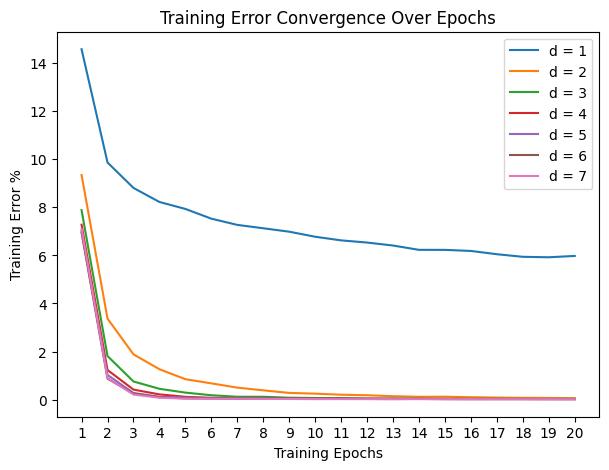

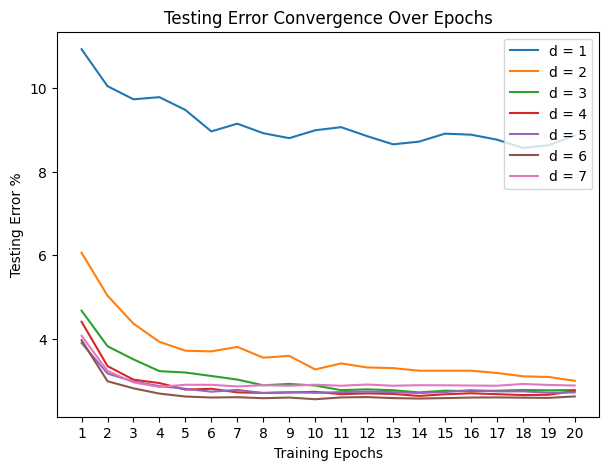

In [ ]:
plot_epochs(combo, True)

For a kernel perceptron using the One vs. Rest method and a polynomial kernel, both training and testing errors converge around 12 training epochs. For consistency, we choose to use 12 training epochs for all further experiments.

##1: Basic Results

Mean training and testing errors with standard deviation over 20 runs for different values of d in the range [1, 7] in a model using a One vs. Rest classifier with a polynomial kernel.

In [ ]:
run_model(combo, True, 1, 1, 7)

Mean Errors with SD

d = 1.0
Training: 6.5428 ± 0.2640%
Testing: 8.8441 ± 1.2518%

d = 2.0
Training: 0.1634 ± 0.0483%
Testing: 3.2608 ± 0.3730%

d = 3.0
Training: 0.0430 ± 0.0151%
Testing: 2.8978 ± 0.3125%

d = 4.0
Training: 0.0370 ± 0.0228%
Testing: 2.7419 ± 0.3513%

d = 5.0
Training: 0.0229 ± 0.0142%
Testing: 2.5403 ± 0.4212%

d = 6.0
Training: 0.0255 ± 0.0159%
Testing: 2.6801 ± 0.3223%

d = 7.0
Training: 0.0175 ± 0.0121%
Testing: 2.7769 ± 0.4285%



##2: Cross-validation

Mean testing error and d* parameter with standard deviation over 20 runs for a d parameter selected via 5-fold cross-validation from values in the range [1, 7]. The model uses a One vs. Rest classifier with a polynomial kernel.

In [ ]:
vals, preds, ims = run_model_cv(combo, True, 1, 1, 7)

Starting run 1...
Starting run 3...
Starting run 5...
Starting run 7...
Starting run 9...
Starting run 11...
Starting run 13...
Starting run 15...
Starting run 17...
Starting run 19...

Mean Errors with SD

Testing: 2.5242 ± 0.3894%

Mean d* with SD

Mean d* parameter: 4.7000 ± 0.8426


##3: Confusion Matrix

Confusion matrix showing the mean predicted label-true label error rates and standard deviations across testing images. The predictions are sourced from all 20 runs of the above 5-fold cross-validation experiment above.

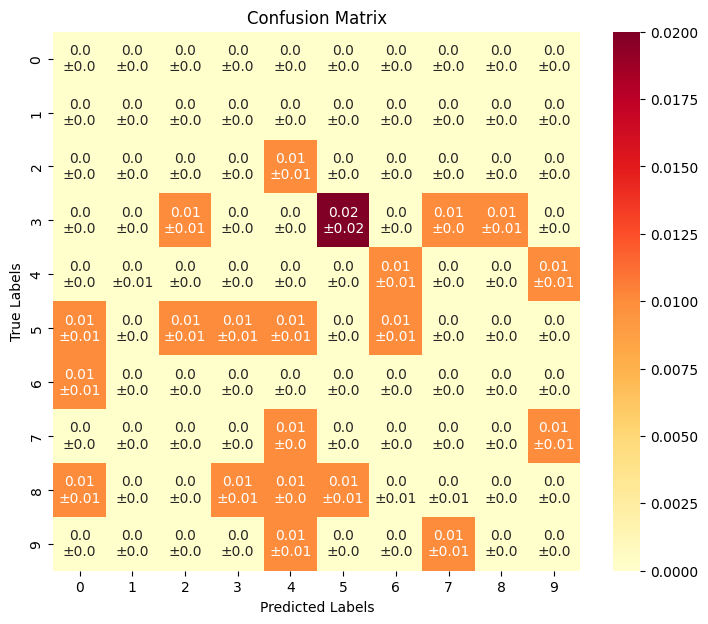

In [ ]:
plot_cm(vals, preds, ims)

##4: Hardest to Predict Images

The five images and their true labels which were most frequently misclassified in the 20 runs of the above 5-fold cross-validation experiment above.

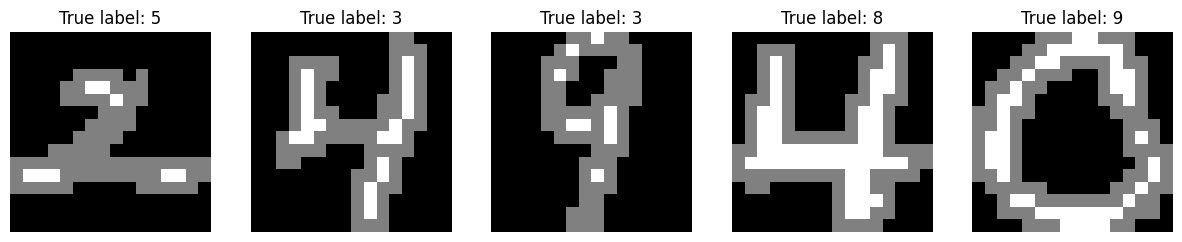

In [ ]:
plot_top_five(vals, preds, ims)

##5: Gaussian Kernel

###Repeat of 1: Basic Results

####Initial experiments for selecting c* range

Mean training and testing errors with standard deviation over 20 runs for different values of exponentially-spaced c in the range [0.0000, 1.0000] in a model using a One vs. Rest classifier with a Gaussian kernel.

In [ ]:
run_model(combo, False, 1, -10, 0)

Mean Errors with SD

c = 0.0000
Training: 13.6771 ± 0.4919%
Testing: 13.5672 ± 3.9594%

c = 0.0002
Training: 8.9715 ± 0.3233%
Testing: 10.6452 ± 3.7775%

c = 0.0013
Training: 2.4825 ± 0.2005%
Testing: 5.3952 ± 1.1404%

c = 0.0067
Training: 0.0343 ± 0.0188%
Testing: 2.8038 ± 0.3460%

c = 0.0357
Training: 0.0114 ± 0.0115%
Testing: 3.1613 ± 0.3890%

c = 0.1889
Training: 0.0000 ± 0.0000%
Testing: 6.2446 ± 0.6759%

c = 1.0000
Training: 0.0000 ± 0.0000%
Testing: 6.5887 ± 0.5313%



Mean training and testing errors with standard deviation over 20 runs for different values of exponentially-spaced c in the range [0.0014, 0.0369] in a model using a One vs. Rest classifier with a Gaussian kernel.

In [ ]:
run_model(combo, False, 1, -6.6, -3.3)

Mean Errors with SD

c = 0.0014
Training: 2.1988 ± 0.1280%
Testing: 6.0134 ± 1.2910%

c = 0.0024
Training: 0.6877 ± 0.1161%
Testing: 4.1102 ± 0.6012%

c = 0.0041
Training: 0.1358 ± 0.0452%
Testing: 3.0753 ± 0.2531%

c = 0.0071
Training: 0.0363 ± 0.0160%
Testing: 2.6855 ± 0.3608%

c = 0.0123
Training: 0.0222 ± 0.0149%
Testing: 2.5672 ± 0.5234%

c = 0.0213
Training: 0.0208 ± 0.0124%
Testing: 2.5161 ± 0.3657%

c = 0.0369
Training: 0.0141 ± 0.0124%
Testing: 3.1855 ± 0.4495%



####Testing with selected c*s

Mean training and testing errors with standard deviation over 20 runs for different values of exponentially-spaced c in the range [0.0071, 0.0369] in a model using a One vs. Rest classifier with a Gaussian kernel.

In [ ]:
run_model(combo, False, 1, -4.95, -3.3)

Mean Errors with SD

c = 0.0071
Training: 0.0336 ± 0.0124%
Testing: 2.7124 ± 0.3187%

c = 0.0093
Training: 0.0336 ± 0.0231%
Testing: 2.6156 ± 0.3397%

c = 0.0123
Training: 0.0269 ± 0.0085%
Testing: 2.6290 ± 0.3906%

c = 0.0162
Training: 0.0269 ± 0.0085%
Testing: 2.5833 ± 0.3734%

c = 0.0213
Training: 0.0128 ± 0.0116%
Testing: 2.5349 ± 0.3444%

c = 0.0280
Training: 0.0141 ± 0.0116%
Testing: 2.8763 ± 0.3949%

c = 0.0369
Training: 0.0148 ± 0.0103%
Testing: 3.1129 ± 0.3318%



###Repeat of 2: Cross-validation

Mean testing error and c* parameter with standard deviation over 20 runs for a c parameter selected via 5-fold cross-validation from values in the range [0.0071, 0.0369]. The model uses a One vs. Rest classifier with a Gaussian kernel.

In [ ]:
vals, preds, ims = run_model_cv(combo, False, 1, -4.95, -3.3)

Starting run 1...
Starting run 3...
Starting run 5...
Starting run 7...
Starting run 9...
Starting run 11...
Starting run 13...
Starting run 15...
Starting run 17...
Starting run 19...

Mean Errors with SD

Testing: 2.5565 ± 0.2636%

Mean c* with SD

Mean c* parameter: 0.0150 ± 0.0032


##6: One vs. One Classifier

###Repeat of 1: Basic Results

Mean training and testing errors with standard deviation over 20 runs for different values of d in the range [1, 7] in a model using a One vs. One classifier with a polynomial kernel.

In [ ]:
run_model(combo, True, 2, 1, 7)

Mean Errors with SD

d = 1.0
Training: 2.6123 ± 0.2173%
Testing: 6.4624 ± 0.6982%

d = 2.0
Training: 0.0867 ± 0.0493%
Testing: 3.4839 ± 0.4906%

d = 3.0
Training: 0.0511 ± 0.0215%
Testing: 3.2312 ± 0.3007%

d = 4.0
Training: 0.0316 ± 0.0177%
Testing: 3.0860 ± 0.3519%

d = 5.0
Training: 0.0430 ± 0.0211%
Testing: 3.3306 ± 0.4145%

d = 6.0
Training: 0.0370 ± 0.0216%
Testing: 3.4167 ± 0.4086%

d = 7.0
Training: 0.0269 ± 0.0147%
Testing: 3.4597 ± 0.4282%



###Repeat of 2: Cross-validation

Mean testing error and d* parameter with standard deviation over 20 runs for a d parameter selected via 5-fold cross-validation from values in the range [1, 7]. The model uses a One vs. One classifier with a polynomial kernel.

In [12]:
run_model_cv(combo, True, 2, 1, 7)

Starting run 1...
Starting run 3...
Starting run 5...
Starting run 7...
Starting run 9...
Starting run 11...
Starting run 13...
Starting run 15...
Starting run 17...
Starting run 19...

Mean Errors with SD

Testing: 3.2231 ± 0.4496%

Mean d* with SD

Mean d* parameter: 3.5000 ± 0.6708
